In [0]:
import sqlalchemy
import pandas as pd
import numpy as np
import re
import os
import sqlite3
import ast
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir('/content/gdrive/My Drive/Data/')

In [0]:
text_merged = pd.read_csv('text_merged.csv')

## Working with extracted data

In [0]:
family_cases = pd.read_csv('family_cases_features.txt', ';', header=None)
family_cases.columns = ['id', 'outcome', 'outcomeFull', 'length', 'n_judges', 'judges_names', 'sex']

family_decisions = pd.read_csv('family_cases_1819.csv')

In [0]:
aliments_df = pd.read_csv('aliments_texts.csv')

In [0]:
fc_df = pd.merge(family_cases, family_decisions, left_on='id', right_on='doc_id').drop(['receipt_date', 'doc_url', 'status', 
                                                                                'date_publ', 'j_form_name', 'j_kind_name', 'doc_id'], axis=1)

aliments_merged = pd.merge(fc_df, aliments_df)

aliments_merged.shape

(81509, 16)

In [0]:
aliments_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81509 entries, 0 to 81508
Data columns (total 16 columns):
id                   81509 non-null float64
outcome              81509 non-null object
outcomeFull          81500 non-null object
length               81509 non-null float64
n_judges             79182 non-null float64
judges_names         79182 non-null object
sex                  79182 non-null object
court_code           81509 non-null int64
judgment_code        81509 non-null float64
justice_kind         81509 non-null float64
category_code        81509 non-null float64
cause_num            81500 non-null object
adjudication_date    81509 non-null object
judge                81509 non-null object
category_name        81509 non-null object
text                 81509 non-null object
dtypes: float64(6), int64(1), object(9)
memory usage: 10.6+ MB


In [0]:
aliments_merged.dropna(inplace=True)

In [0]:
def get_outcome(row):
    try:
        
        doc_id = row.id
        outcomes_list = [case for case in row.outcomeFull if float(case['id']) == doc_id][0]['outcomeFull']

        outcome = 0

        for i in outcomes_list:
            if i in ['Відмовлено у задоволенні скарги', 'Рішення залишено без змін', 'Відмовлено у задоволенні позову']:
                outcome += 0
            elif i in ['Позов задоволено', 'Скарга задоволена', 'Позов задоволено частково', 'Накладено стягнення']:
                outcome += 1
        
        if outcome >= 2: # to handle cases like  ['Позов задоволено частково', 'Скарга задоволена']
                        # was == 2, but not > 2 to handle cases like ['Позов задоволено', 'Скарга задоволена', 'Накладено стягнення']
            outcome = 1
        return outcome
    
    except IndexError:
        
        return None

In [0]:
def get_judge_sex(row):
    try:
        stemmed_names = []
        for name in row.judges_names:
            shorten = ' '.join([j[0]+'.' if i == 1 or i == 2 else j for i, j in enumerate(name.split())])
            stemmed_names.append(shorten)

        idx = [stemmed_names.index(judge) for judge in stemmed_names if judge.replace(' ', '') == row.judge.replace(' ', '')][0]

        return 0 if row.sex[idx] == 'чоловік' else 1
    
    except IndexError:
        return None

In [0]:
family_durations = pd.read_csv('family_cases_duration.csv')

In [0]:
courts = pd.read_csv('courts.csv', '\t')
instances = pd.read_csv('instances.csv', '\t')

In [0]:
aliments_merged = pd.merge(aliments_merged, pd.merge(courts, instances, on='instance_code')).rename({'name_x': 'court_name',
                                                                                  'name_y': 'instance'}, axis=1)

In [0]:
# getting durations instance-wise

aliments_merged = pd.merge(aliments_merged, family_durations, 
                           left_on=['cause_num', 'instance'], right_on=['cause_num', 'name_y'])

In [0]:
aliments_merged['duration_days'] = aliments_merged.adjudication_date_y.apply(lambda x: pd.to_timedelta(x).days)
aliments_merged.drop(['name_y', 'adjudication_date_y'], axis=1, inplace=True)

In [0]:
aliments_merged['duration_days'].head()

0    183
1    145
2    145
3    222
4    118
Name: duration_days, dtype: int64

In [0]:
# getting outcomes

aliments_merged['outcomeFull'] = aliments_merged['outcomeFull'].apply(ast.literal_eval)

aliments_merged = aliments_merged[~aliments_merged['sex'].isin(['[null]'])]
aliments_merged['sex'] = aliments_merged.sex.apply(lambda x: x.replace('null', '"null"')).apply(ast.literal_eval)
aliments_merged['sex'] = aliments_merged['sex'].apply(str).apply(ast.literal_eval)

aliments_merged['outcome_kind'] = aliments_merged.outcome

aliments_merged['outcome'] = aliments_merged.apply(get_outcome, axis=1)

aliments_merged['judges_names'] = aliments_merged['judges_names'].apply(ast.literal_eval)

In [0]:
# almost all aliment cases are approval which is not surprise

aliments_merged.groupby('instance').outcome.mean()

instance
Апеляційна    0.351659
Перша         0.936565
Name: outcome, dtype: float64

In [0]:
# getting sex categoricals of judges

aliments_merged['bin_sex'] = aliments_merged.apply(get_judge_sex, axis=1)

aliments_merged.dropna(subset=['bin_sex'], inplace=True)

In [0]:
# equal proportion of male/female judges
aliments_merged.bin_sex.mean()

0.5286907293080924

In [0]:
aliments_merged.groupby(['bin_sex', 'instance']).outcome.mean()

bin_sex  instance  
0.0      Апеляційна    0.331673
         Перша         0.933829
1.0      Апеляційна    0.364794
         Перша         0.939150
Name: outcome, dtype: float64

In [0]:
aliments_merged.groupby(['bin_sex', 'instance']).outcome.mean()

bin_sex  instance  
0.0      Апеляційна    0.331673
         Перша         0.933829
1.0      Апеляційна    0.364794
         Перша         0.939150
Name: outcome, dtype: float64

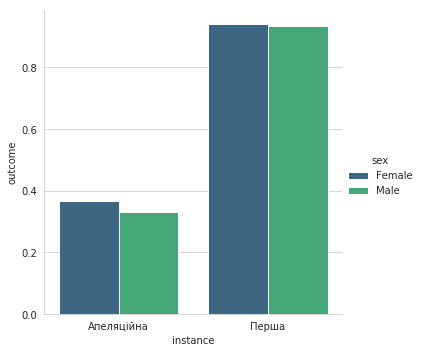

In [0]:
# equal rates which is also not surprise

aliments_merged['sex'] = aliments_merged.bin_sex.map({0: 'Male', 1: 'Female'})

mean_outcomes_by_sex = aliments_merged.groupby(['sex', 'instance']).outcome.mean().reset_index()

sns.catplot(x='instance', y='outcome', hue='sex', data=mean_outcomes_by_sex, kind='bar', palette='viridis');

In [0]:
def get_aliments_sum(row):
    
    try:
    
        s1 = row

        s2 = re.compile(r'ВИРІШИВ:.*', re.I).search(s1).group(0)
        s2 = re.sub(r'\([\w\s]+\)', '', s2) # replace digits spelled by word characters


        pattern = re.compile(r'\s\d*,?\s?\d+,?\s?(\(?\w*\s?\w*\)?\s?)(грн|гривень)')

        matched_objects = [match.group(0).replace('грн', '').replace('гривень', '').replace(',', '.').replace(' ', '').strip()
                            for match in pattern.finditer(s2)]


        # at first we will not split the court fee and sum

        return sum([float(m) for m in matched_objects])
    
    except:
        
        return None


In [0]:
aliments_merged['aliments_sum'] = aliments_merged.text.apply(get_aliments_sum)

In [0]:
aliments_merged.groupby('instance').aliments_sum.apply(lambda x: x.isnull().sum()) # still most of the nans are in first instance, not appelation

instance
Апеляційна     2719
Перша         21477
Name: aliments_sum, dtype: int64

In [0]:
reduced_aliments = aliments_merged.copy()

reduced_aliments['aliments_sum'] = reduced_aliments.aliments_sum.replace(0, None)

reduced_aliments.dropna(inplace=True)

reduced_aliments.shape

(51228, 24)

In [0]:
# the string where the value occured was ">30977055254 214,60 гривень" - html tags mess the overall sum

print('max value is:', reduced_aliments.aliments_sum.max())
print('max value is at index', reduced_aliments.aliments_sum.idxmax())

max value is: 2754513228.7
max value is at index 9924


In [0]:
# some of them are not aliment cases, or even not civil ones

reduced_aliments = reduced_aliments.drop([61332, 9924, 17906, 48015, 26173, 19081, 19082])

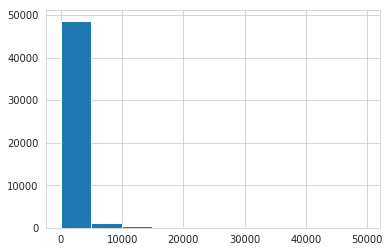

In [0]:
# most of the values are before 5,000 uah

reduced_aliments.aliments_sum[reduced_aliments.aliments_sum < 50_000].hist();

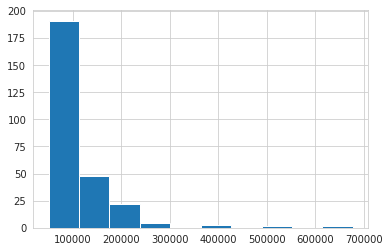

In [0]:
reduced_aliments.aliments_sum[reduced_aliments.aliments_sum > 50_000].hist();

In [0]:
aliments_merged.groupby('sex').size()

sex
Female    41277
Male      36797
dtype: int64

In [0]:
# mean aliments sum by sex

reduced_aliments['sex'] = aliments_merged.bin_sex.map({0: 'Male', 1: 'Female'})

reduced_aliments.groupby('sex')['aliments_sum'].mean()

sex
Female    2498.041368
Male      2327.115069
Name: aliments_sum, dtype: float64

In [0]:
# aliments_merged.drop('text', axis=1).to_csv('aliments_merged.csv', index=False)

In [0]:
# median aliments sum without outliers is much lower

reduced_aliments.groupby('sex')['aliments_sum'].median()

sex
Female    704.8
Male      768.0
Name: aliments_sum, dtype: float64

In [0]:
# same proportion everywhere

for treshold in [2000, 5000, 10_000, 20_000]:
    print(f'Larger than {treshold} UAH')
    print(reduced_aliments[reduced_aliments.aliments_sum > treshold].groupby('sex')['aliments_sum'].median())
    print()

Larger than 2000 UAH
sex
Female    3000.0
Male      2804.8
Name: aliments_sum, dtype: float64

Larger than 5000 UAH
sex
Female    11976.000
Male      11773.475
Name: aliments_sum, dtype: float64

Larger than 10000 UAH
sex
Female    22215.000
Male      22706.685
Name: aliments_sum, dtype: float64

Larger than 20000 UAH
sex
Female    38709.57
Male      36030.00
Name: aliments_sum, dtype: float64



In [0]:
reduced_aliments[reduced_aliments.aliments_sum > 20_000].outcome.count()

842

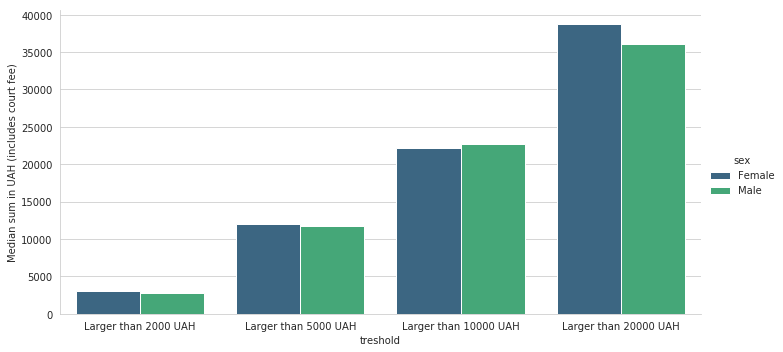

In [0]:
df_list = []

for treshold in [2000, 5000, 10_000, 20_000]:
    df = reduced_aliments[reduced_aliments.aliments_sum > treshold].groupby('sex')['aliments_sum'].median().reset_index()
    df['treshold'] = f'Larger than {treshold} UAH'
    df_list.append(df)
    
all_treshold_dfs = pd.concat(df_list)

sns.catplot(x='treshold', y='aliments_sum', hue='sex', data=all_treshold_dfs, kind='bar', palette='viridis', aspect=2);

plt.ylabel('Median sum in UAH (includes court fee)');

In [0]:
# sizes are pretty the same
reduced_aliments[reduced_aliments.aliments_sum > 5000].groupby('bin_sex')['aliments_sum'].size()

bin_sex
0.0    1064
1.0    1469
Name: aliments_sum, dtype: int64

In [0]:
# what about prediction, is there any sense for that or these sums are just common value almost everytime


reduced_aliments.aliments_sum.mode()

0    704.0
dtype: float64

In [0]:
reduced_aliments[reduced_aliments.aliments_sum == 704].shape

(9235, 24)

In [0]:
reduced_aliments.drop(reduced_aliments[reduced_aliments.aliments_sum == 704].index).aliments_sum.mode()

0    704.8
dtype: float64

In [0]:
reduced_aliments[reduced_aliments.aliments_sum == 704.8].shape

(8942, 24)

In [0]:
reduced_aliments[reduced_aliments.aliments_sum > 705].aliments_sum.mode()

0    1000.0
dtype: float64

In [0]:
reduced_aliments[reduced_aliments.aliments_sum == 1000.0].shape

(2172, 24)

In [0]:
# half of the dataset is the value below the 2000, so are just probably minima sum
reduced_aliments[reduced_aliments.aliments_sum < 2000].shape

(39693, 24)

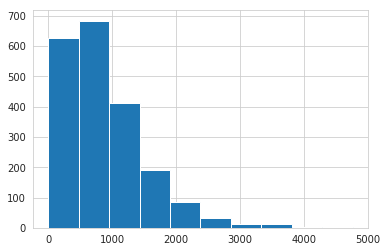

In [0]:
# variability distribution
reduced_aliments[reduced_aliments.aliments_sum < 10_000].groupby('judge').aliments_sum.std().hist();

In [0]:
reduced_aliments['judge_median'] = reduced_aliments.groupby('judge').aliments_sum.transform('median')

reduced_aliments['judge_std'] = reduced_aliments.groupby('judge').aliments_sum.transform('std')

In [0]:
aliments_merged['date'] = aliments_merged.adjudication_date_x.apply(pd.to_datetime)

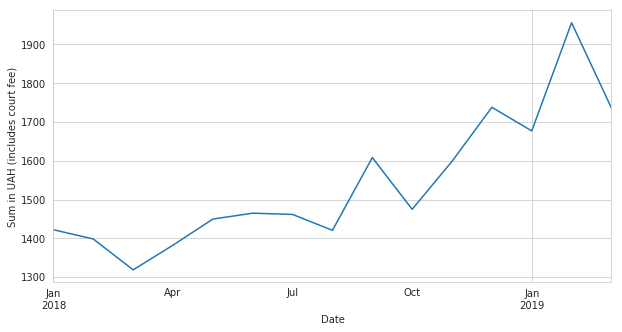

In [0]:
after_2018 = aliments_merged[aliments_merged.date.apply(lambda x: x.date()) > pd.to_datetime('2018-01-01').date()]

after_2018 = after_2018[after_2018.aliments_sum < 100_000]

# does the value of aliments increase? I guess we see the influence of adoption of the new legislation


plt.figure(figsize=(10, 5))
after_2018.set_index(pd.DatetimeIndex(after_2018.date.apply(lambda x: x.date())))\
                        .resample('M').aliments_sum.mean().plot();

plt.xlabel('Date')
plt.ylabel('Sum in UAH (includes court fee)');